https://www.kaggle.com/mgmarques/houses-prices-complete-solution # olhar como referência

# Definição do Problema

- Qual o valor total dos aluguéis por cidade?
- Quantos imóveis ofertados à serem alugados por cidade?
- A área construída influencia no valor dos aluguéis?
- A número de quartos influenciam no valor dos aluguéis?
- Locais em que aceitam animais de estimação deixam os aluguéis mais caros?
- Locais imobiliados deixam os aluguéis mais caros?


### Outros insights

- A população da cidade assim como a renda influencia no valor dos aluguéis?
- Tempo de contrução do imóvel, pode influenciar?
- Vezes em que o imóvel foi alugado?
- Estabelecimentos públicos nas proximidades?

# Importando o Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
df = pd.read_excel('houses_to_rent_v2_Copia.xlsx')
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065.0,3300,211,42.0,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200.0,4960,1750,63.0,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000.0,2800,0,41.0,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270.0,1112,22,17.0,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0.0,800,25,11.0,836


In [3]:
# removendo caracteres especiais e colocando '_' entre os espaços para facilitar a remoção do '(R$)'
df.columns = df.columns.map(lambda x: re.sub(r'\W+', '_', x))

# substituindo nosso padrão por ''
df.columns = df.columns.str.replace('_R_','')

df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor',
       'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax',
       'fire_insurance', 'total'],
      dtype='object')

In [4]:
# separando em dois conjuntos de dados
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8553 entries, 6239 to 7270
Data columns (total 13 columns):
city              8553 non-null object
area              8553 non-null int64
rooms             8553 non-null int64
bathroom          8553 non-null int64
parking_spaces    8553 non-null int64
floor             8553 non-null object
animal            8499 non-null object
furniture         8553 non-null object
hoa               8505 non-null float64
rent_amount       8553 non-null int64
property_tax      8553 non-null int64
fire_insurance    8499 non-null float64
total             8553 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 935.5+ KB


In [6]:
df_train.isnull().sum()

city               0
area               0
rooms              0
bathroom           0
parking_spaces     0
floor              0
animal            54
furniture          0
hoa               48
rent_amount        0
property_tax       0
fire_insurance    54
total              0
dtype: int64

Identificado alguns valores missing

# Tratando dados missing

In [7]:
# começando pela coluna animal
df.animal.value_counts(dropna=False)

acept        8262
not acept    2360
NaN            70
Name: animal, dtype: int64

In [8]:
# vou pegar a cidade como minha referência e vou agrupar
# para saber, qual a proporção de dados missing por cidade
df_train.groupby(['city'])['animal'].value_counts(dropna=False)

city            animal   
Belo Horizonte  acept         767
                not acept     270
                NaN             3
Campinas        acept         546
                not acept     124
                NaN             2
Porto Alegre    acept         798
                not acept     141
                NaN             5
Rio de Janeiro  acept         952
                not acept     237
                NaN            12
São Paulo       acept        3540
                not acept    1124
                NaN            32
Name: animal, dtype: int64

No caso da coluna "animal" não terem muitos dados faltantes, optei em substituir pelo valor mais frequente por cidade

In [9]:
# como cidade é minha referência
# vou criar uma lista para passar em um loop
cidades = df_train.city.unique()

# usando "Imputation" do sklearn para substituir pelo valor mais frequente
imp = SimpleImputer(strategy='most_frequent')

for i in cidades:

    imp.fit(np.array(df_train[df_train.city==i]['animal']).reshape(-1,1))

    df_train.loc[df_train.city==i, 'animal'] = imp.transform(np.array(df_train[df_train.city==i]['animal']).reshape(-1,1))

C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [10]:
# conferindo o resultado
df_train.groupby(['city'])['animal'].value_counts(dropna=False)

city            animal   
Belo Horizonte  acept         770
                not acept     270
Campinas        acept         548
                not acept     124
Porto Alegre    acept         803
                not acept     141
Rio de Janeiro  acept         964
                not acept     237
São Paulo       acept        3572
                not acept    1124
Name: animal, dtype: int64

In [11]:
# checando os dados da coluna "hoa" e "fire_insurance" que são do tipo "float"
df_train.describe()[['hoa','fire_insurance']].T

,count,mean,std,min,25%,50%,75%,max
hoa,8505.0,1244.73980,17473.047438,0.0,160.0,560.0,1250.0,1117000.0
fire_insurance,8499.0,53.58101,48.122362,3.0,21.0,36.0,68.0,677.0


Analisando os valores, observamos outliers nos dois conjuntos. Inicialmente adorarei a seguinte estratégia:
- para a **hoa** vou imputar os valores da **mediana**.
- para o **fire_insurance** vou imputar os valores da **média**.

Acredito que os valores de condomínio e seguro são de acordo com as cidade, depois vou tentar validar esta hipótese.

In [12]:
imp = SimpleImputer(strategy='median')

for i in cidades:

    imp.fit(np.array(df_train[df_train.city==i]['hoa']).reshape(-1,1))

    df_train.loc[df_train.city==i, 'hoa'] = imp.transform(np.array(df_train[df_train.city==i]['hoa']).reshape(-1,1))

C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [13]:
imp = SimpleImputer(strategy='mean')

for i in cidades:

    imp.fit(np.array(df_train[df_train.city==i]['fire_insurance']).reshape(-1,1))

    df_train.loc[df_train.city==i, 'fire_insurance'] = imp.transform(np.array(df_train[df_train.city==i]['fire_insurance']).reshape(-1,1))

C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [14]:
# checando se todos os dados foram preenchidos:
df_train.isnull().sum()

city              0
area              0
rooms             0
bathroom          0
parking_spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent_amount       0
property_tax      0
fire_insurance    0
total             0
dtype: int64

In [15]:
# olhando o tipo das features
df_train.select_dtypes(include='object')

,city,floor,animal,furniture
6239,São Paulo,19,acept,furnished
9805,São Paulo,-,acept,not furnished
10314,Campinas,6,acept,not furnished
10072,Porto Alegre,1,acept,furnished
3026,São Paulo,12,acept,not furnished
...,...,...,...,...
5734,São Paulo,1,not acept,furnished
5191,São Paulo,1,not acept,not furnished
5390,Rio de Janeiro,11,acept,furnished
860,São Paulo,5,not acept,furnished


In [16]:
# a feature "floor" já está no formato, porém está como 'str' por causa de um '-'
# vou alterar o '-' para 0

df_train.floor = df.floor.replace('-',0)

C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Agora sim, podemos responder às perguntas iniciais

### Qual valor total dos aluguéis por cidades?

In [17]:
df_train.groupby(['city'])['rent_amount'].sum().sort_values(ascending = False)

city
São Paulo         22015513
Rio de Janeiro     3890031
Belo Horizonte     3798487
Porto Alegre       2213103
Campinas           1580501
Name: rent_amount, dtype: int64

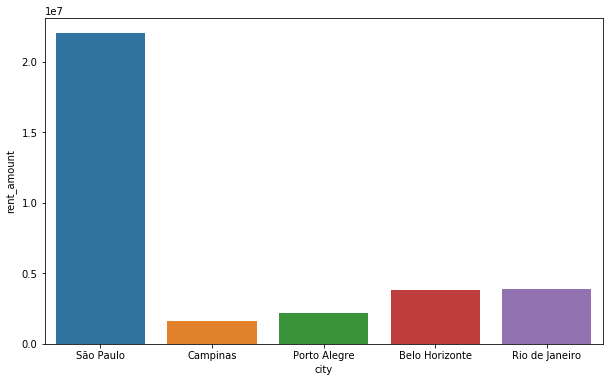

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(x='city', y='rent_amount', data=df_train, estimator=sum, ci=None)

### Quantos imóveis com ofertas à serem alugados por cidade?

In [19]:
df_train.groupby(['city'])['rent_amount'].count().sort_values(ascending = False)

city
São Paulo         4696
Rio de Janeiro    1201
Belo Horizonte    1040
Porto Alegre       944
Campinas           672
Name: rent_amount, dtype: int64

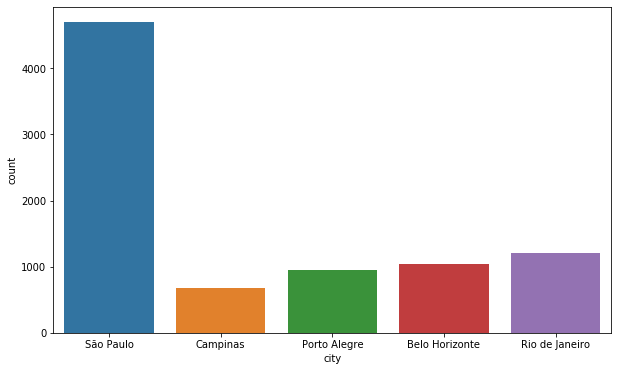

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(x='city', data=df_train)

Observamos que a proporção do valor e quantidade se relacionam, por exemplo, o valor total dos aluguéis é maior porque tenho mais imóveis alugados.

### A área construída influencia no valor dos aluguéis?

In [21]:
np.log(df_train[['area','rent_amount']]).corr()

,area,rent_amount
area,1.000000,0.725525
rent_amount,0.725525,1.000000


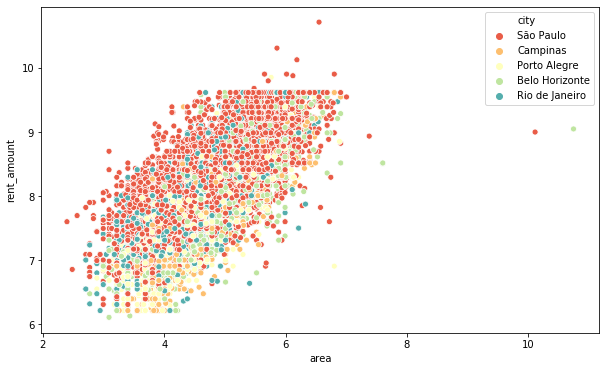

In [22]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=np.log(df_train.area), y=np.log(df_train.rent_amount), data=df_train, hue='city', palette='Spectral')

A área construída correlaciona com a o valor dos alugueis.

E com relação ao total (junto com condomínio e seguro)?

In [23]:
np.log(df_train[['area','rent_amount']]).corr()

,area,rent_amount
area,1.000000,0.725525
rent_amount,0.725525,1.000000


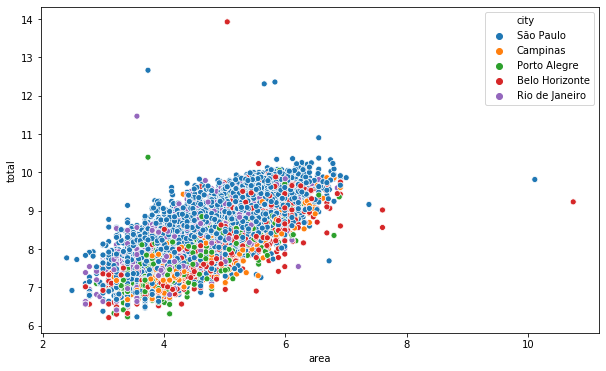

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=np.log(df_train.area), y=np.log(df_train.total), data=df_train, hue='city')

Sim, são correlacionados.

### A quantidade de quartos influenciam no valor dos aluguéis?

In [25]:
np.log(df_train[['rooms','rent_amount']]).corr()

,rooms,rent_amount
rooms,1.000000,0.569681
rent_amount,0.569681,1.000000


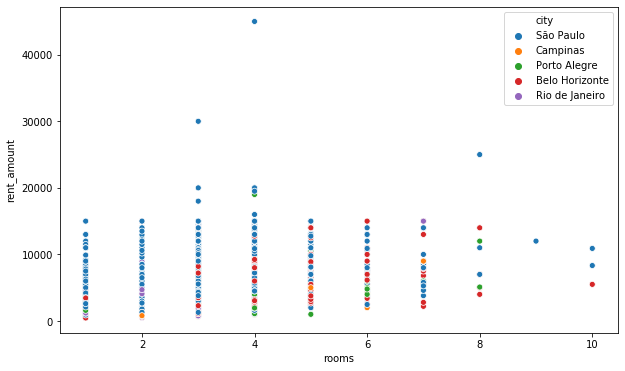

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_train.rooms, y=df_train.rent_amount, data=df_train, hue='city')

Vou converter as variáveis categóricas qualitativas para quantitativas, para seguir respondendo as outras questões

In [27]:
# selecionando as variáveis categóricas
df_train.select_dtypes(['object']).columns

Index(['city', 'animal', 'furniture'], dtype='object')

In [28]:
# para a primeira feature vou utilizar o label encoder
# instanciando a LabelEncoder
le = LabelEncoder()

le.fit(df_train.city)

df_train['city'] = le.transform(df_train.city)

C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [29]:
# nesse caso vou fazer algo mais simples
df_train['animal'] = df_train.animal.map({'acept':1, 'not acept':0})
df_train['furniture'] = df_train.furniture.map({'furnished':1, 'not furnished':0})

C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
df_train.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
6239,4,200,3,4,3,19,1,1,2247.0,8500,1000,33.0,11780
9805,4,225,3,2,2,0,1,0,0.0,2300,209,35.0,2544
10314,1,53,1,1,0,6,1,0,403.0,500,15,7.0,925
10072,2,42,1,1,1,1,1,1,650.0,2400,81,36.0,3167
3026,4,101,2,2,1,12,1,0,582.0,1700,0,22.0,2304


### Locais em que aceitam animais de estimação deixam os aluguéis mais caros?

In [31]:
df_train[['animal', 'rent_amount']].corr()

,animal,rent_amount
animal,1.000000,0.071424
rent_amount,0.071424,1.000000


A aceitação de animal não correlaciona com o preço dos aluguéis, poia a correlação está bem próxima de zero.

### Locais imobiliados deixam os aluguéis mais caros?

In [32]:
df_train[['furniture', 'rent_amount']].corr()

,furniture,rent_amount
furniture,1.000000,0.169457
rent_amount,0.169457,1.000000


Tem uma correlação bem fraca.

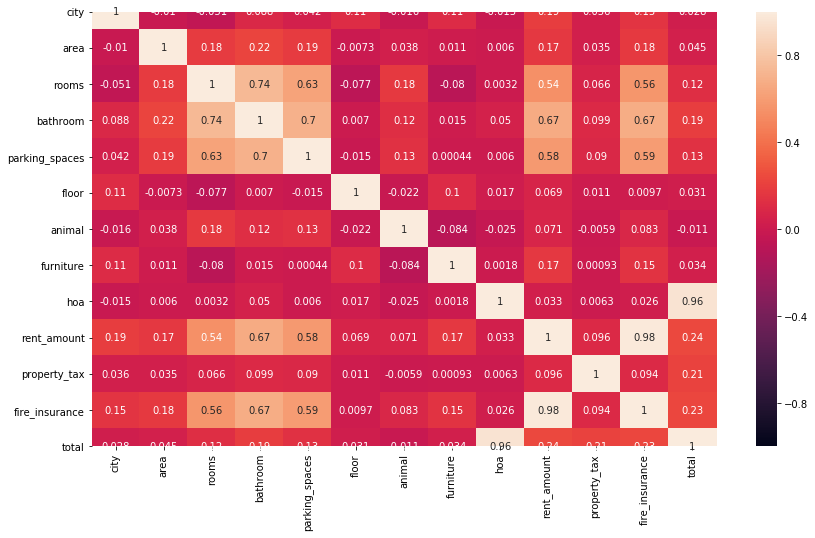

In [33]:
# heatmap para visulizalização geral dos dados com a correlação
plt.figure(figsize=(14,8))
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)

Temos várias features que se relacionam entre si e para um modelo de Machine Learning isso não é muito bom.

# Um olhar mais estatístico

Esta função mostra alguns parâmetros já analisados anteriormente, sumarizando junto com outras análises estatísticas, como a Skewness e Kurtosis, além de, passando a variável target como parâmetro da função nos retorna a correlação com as outras variáveis. Vejamos abaixo o resultado.

In [34]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [35]:
details = rstr(df_train, 'rent_amount')
display(details.sort_values(by='corr rent_amount', ascending=False))

Data shape: (8553, 13)
___________________________
Data types:
 int64      10
float64     2
int32       1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr rent_amount
rent_amount,int64,8553,1059,0,0.0,"[[8500.0, 2300.0, 500.0, 2400.0, 1700.0, 2800....",1.848868,4.927001,1.000000
fire_insurance,float64,8553,219,0,0.0,"[[33.0, 35.0, 7.0, 36.0, 22.0, 14.0, 91.0, 155...",2.004316,6.543382,0.984801
bathroom,int64,8553,10,0,0.0,"[[4.0, 2.0, 1.0, 3.0, 5.0, 6.0, 7.0, 10.0, 8.0...",1.199647,1.069948,0.667071
parking_spaces,int64,8553,10,0,0.0,"[[3.0, 2.0, 0.0, 1.0, 6.0, 4.0, 5.0, 8.0, 7.0,...",1.449339,2.546469,0.579275
rooms,int64,8553,10,0,0.0,"[[3.0, 1.0, 2.0, 4.0, 5.0, 7.0, 6.0, 10.0, 8.0...",0.661414,1.065927,0.541253
total,int64,8553,5085,0,0.0,"[[11780.0, 2544.0, 925.0, 3167.0, 2304.0, 4826...",53.907799,3234.414865,0.239565
city,int32,8553,5,0,0.0,"[[4.0, 1.0, 2.0, 0.0, 3.0]]",-0.999689,-0.482017,0.190821
area,int64,8553,490,0,0.0,"[[200.0, 225.0, 53.0, 42.0, 101.0, 136.0, 70.0...",67.546498,5040.854869,0.171638
furniture,int64,8553,2,0,0.0,"[[1.0, 0.0]]",1.201887,-0.555597,0.169457
property_tax,int64,8553,1136,0,0.0,"[[1000.0, 209.0, 15.0, 81.0, 0.0, 500.0, 100.0...",87.743661,7966.665160,0.096305


### Breve definição:

- **Skewness:** é o grau de distorção da curva simétrica de distribuição normal. Ela mede a falta de simetria e há dois tipos:
    - **Skewness positivo:** quando a cauda do lado direito da distribuição é mais longa, onde a média e a mediana são maiores que a moda.
    - **Skewness negativo:** quando a cauda do lado esquerdo da distribuição é mais longa, onde a média e a mediana são menores que a moda.
    
- **Kurtosis:** é o "achatamento" da curva de distribuição normal, informações sobre as caudas podemos medir a presença de outliers na distribuição:
    - **Alta Kurtosis:** é um indicador de "caudas pesadas", longas, indicando presença de outliers, pode-se investigar o porquê dos outliers, investigando algumas causas como dados incorretos, por exemplo.
    - **Baixa Kurtosis:** é um indicador de "caudas leves", curtas, ou sem presença de outliers. Se tivermos baixa kurtosis (muito pra ser verdade), podemos investigar e eliminar resultados não desejados.
    
*adaptado de: https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa*

### Análise:

- A variável dependente, **rent_amount** está "*skewed*" (1.8489), ou seja, a distribuição não está aproximadamente normal, e sim com uma inclinação positiva, onde a cauda do lado direito é maior que a do lado esquerdo. Podemos confirmar com o gráfico abaixo.

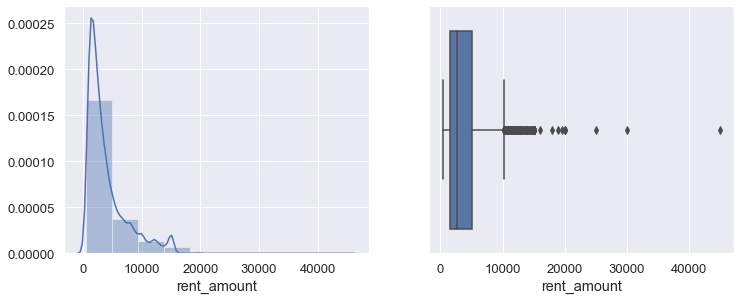

In [36]:
fig = plt.figure(figsize=(12,10))
sns.set(font_scale=1.2)

fig1 = fig.add_subplot(221)
sns.distplot(df_train['rent_amount'], bins=10)

fig2 = fig.add_subplot(222)
sns.boxplot(df_train['rent_amount'])

Com o gráfico de boxplot, podemos comprovar mais claramente a presença de outliers no conjunto de dados dessa feature.

## Multicolinearidade

A função abaixo sugere as features, variáveis explicativas ou preditoras, que se correlacionam entre si. Para um modelo de Machine Learning isso não é tão bom, pois variáveis preditoras que se correlacionam entre si, podem "enviesar" o modelo e o recomendado é tirar pelo menos uma ou mais dessas.

Segundo a documentação do "statsmodels", o resultado do teste de "Variance Infation Factor (VIF)", recomenda tirar quando o valor está acima de 5.0, porque é altamente colinear com as outras variáveis explicativas, e as estimativas dos parâmetros terão grandes erros padrão por causa disso.

https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [38]:
# quero verificar somente as variáveis de interesse do modelo, retirando a variável target (rent_amount)
# e a variável total que é uma soma de outras variáveis e não tem valor preditivo
calculate_vif_(df_train.drop(['rent_amount','total'], axis=1))

dropping 'bathroom' at index: 3
dropping 'rooms' at index: 2
Remaining variables:
Index(['city', 'area', 'parking_spaces', 'floor', 'animal', 'furniture', 'hoa',
       'property_tax', 'fire_insurance'],
      dtype='object')


,city,area,parking_spaces,floor,animal,furniture,hoa,property_tax,fire_insurance
6239,4,200,3,19,1,1,2247.0,1000,33.0
9805,4,225,2,0,1,0,0.0,209,35.0
10314,1,53,0,6,1,0,403.0,15,7.0
10072,2,42,1,1,1,1,650.0,81,36.0
3026,4,101,1,12,1,0,582.0,0,22.0
...,...,...,...,...,...,...,...,...,...
5734,4,17,0,1,0,1,300.0,50,27.0
5191,4,104,2,1,0,0,1040.0,0,49.0
5390,3,100,0,11,1,1,670.0,375,61.0
860,4,53,1,5,0,1,1132.0,0,33.0
